# A/B Testing
#### By Ayman El Taweel 

## Preliminary Wrangling

> This notebook includes an A/B test, in order to make a decision whether to launch a new web page or not. We are going to test the feasibility of both options then determine the more effective one which has both statistical and practical significant effects on conversion rates. 

> The sequence of our project will be as following:
- [Data wrangling ](#Data)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



In [1]:
#### Importing all packages 

import numpy as np
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import statsmodels.api as sm
import random

#We are setting the seed to assure getting the same answers 
random.seed(42)

> Firstly, We will Load in our dataset and then describing its properties through points below.


In [2]:
#### Reading our dataset in a data frame and then viewing the top rows:
df = pd.read_csv('ab_data.csv');
display(df.head());

#### Getting our dataset dimensions
display(df.shape);

#### no. of unique users
display(df['user_id'].nunique());

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


(294478, 5)

290584

### The structure of your dataset:

> Our dataset consists of 294,478 rows & 5 columns.

### The number of unique users:

> Our dataset contains 290,584 unique users.


# Data wrangling

1) Column Cleaning:

In [7]:
#### Unifying columns to be in small letters and separated by '-'

df.rename(columns=lambda x : x.strip().lower().replace(' ','_'),inplace = True)
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


-----------------------------------------------------------------------------------------------------------------------------------

2) Dealing with null values:

In [12]:
# Detecting null values in our dataset:

df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> Our dataset is clear of nulls

--------------------------------------------------------------------------------------------------------------------------------------------------

3) Dealing with duplicates:

In [14]:
# Getting duplicates from our dataset:

df.duplicated().sum()

0

> Our dataset is clear of nulls

---------------------------------------------------------------------------------------------------------------------------------------------------------

4) Assuring the consistency of our test group:

In [15]:
# The number of times the A-option and treatment don't match.

display(df.query('group == "treatment" and landing_page == "old_page"').shape[0])

# The number of times the B-option and control don't match.

display(df.query('group == "control" and landing_page == "new_page"').shape[0])

# Total no. of mismatchings is :
display(df.query('group == "treatment" and landing_page == "old_page"').shape[0] + df.query('group == "control" and landing_page == "new_page"').shape[0])

1965

1928

3893

In [16]:
# To  assure that our dataframe instances are consistent and reliable, we would neglect the mismatched groups with landing pages, 
# and then create a new reliable data frame

df2 = df.query('group == "control" and landing_page == "old_page"')
df2 = df2.append(df.query('group == "treatment" and landing_page == "new_page"'))

In [17]:
# checking the new dataframe if there is any mismatching

display(df2.query('group == "control" and landing_page == "new_page"'))
display(df2.query('group == "treatment" and landing_page == "old_page"'))

,user_id,timestamp,group,landing_page,converted


,user_id,timestamp,group,landing_page,converted


------------------------------------------------------------------------------------------------------------------------------------

5) Dealing with duplicated **_ids:

In [18]:
# Getting the duplicated **_id
display(df2['user_id'].value_counts().head(1))

773192    2
Name: user_id, dtype: int64

In [19]:
# Viewing the duplicated **_id
df2.query('user_id == "773192 "')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [20]:
# As we can see there is no difference( i.e same group and same conversion status) 
# so, we can remove only a row not both of them 

df2.drop_duplicates(subset = 'user_id',inplace =True)

In [21]:
# Finally, We will end our data wrangling by assuring that the no. of unique users = the no. of instances.
(df2.shape[0] == df2['user_id'].nunique())

True

------------------------------------------------------------------------------------------------------------------------------------

## Part I - Probability

#### The probability of:
>1) converting regardless of the page they receive.

>2) converting if he/she is receiving old_page.

>3) converting if he/she is receiving new_page.


In [22]:
# The probability of:
#   
display(df2.converted.mean())
display(df2[df2['group'] == 'control']['converted'].mean())
display(df2[df2['group'] == 'treatment']['converted'].mean())

0.11959708724499628

0.1203863045004612

0.11880806551510564

In [23]:
# The probability that an individual received the new page

df2[df2['landing_page'] == 'new_page'].landing_page.count()/df2.shape[0]

0.5000619442226688

In [24]:
# The probability that an individual received the old page

df2[df2['landing_page'] == 'old_page'].landing_page.count()/df2.shape[0]

0.4999380557773312

### Conclusion:
>*Given these probabilities, Our results would be that both **"old_page and new_page"** reults in nearly equal conversions.*

>*( i.e There is no practical significant difference)*

--------------------------------------------------

## Part II - A/B Test



#### We will assume our hypothesis as follows:

>Null : **$p_{new}$** - **$p_{old}$** <= 0

>ALT  : **$p_{new}$** - **$p_{old}$** >  0

>Type I error rate of 5%

> *where p is a symbol for conversion rate according to landing_page*

*  The **conversion rate** for $p_{new}$ under the null? 

In [25]:
print('Pnew = ',df2.converted.mean())

Pnew =  0.11959708724499628


*  The **conversion rate** for $p_{old}$ under the null? 

In [26]:
print('Pold = ',df2.converted.mean())

Pold =  0.11959708724499628


* The number of individuals in the treatment group,$n_{new}$

In [29]:
# The number of individuals in the treatment group
n_new = df2[df2['group'] == 'treatment'].converted.count()
print('n_new = ',n_new)

n_new =  145310


* The number of individuals in the control group,$n_{old}$

In [30]:
# The number of individuals in the control group
n_old = df2[df2['group'] == 'control'].converted.count()
print('n_old = ',n_old)

n_old =  145274


* Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null. Then, Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
# Simulating (new transactions) with (new conversion) rates under the null :

null_new = df2[df2['group'] == 'treatment'].sample(n_new, replace = True)
new_page_converted = null_new.converted.mean()
new_page_converted

0.11915903929529971

* Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null. Then, Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
# Simulating (old transactions) with (old conversion rates) under the null :

null_old = df2[df2['group'] == 'control'].sample(n_old, replace = True)
old_page_converted = null_old.converted.mean()
old_page_converted   

0.12045513994245358

* $p_{new}$ - $p_{old}$ for the simulated values

In [33]:
# Actual difference between old and new conversions :
actual_diff = new_page_converted - old_page_converted
actual_diff

-0.0012961006471538666

--------------------------------------------------------------------------------------------------------------------------------------

#### Now, We will generate 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in the previous parts. Then, We will Store all the  10,000 values in a NumPy array called **p_diffs**.

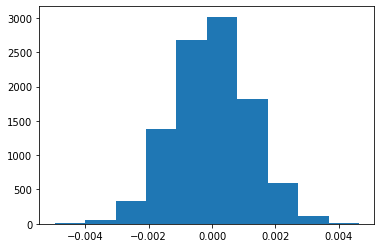

In [34]:
# Bootstrapping to get the normal distribution of p_new - p_old :

p_diffs = []
new_page_converted = np.random.binomial(n_new, 0.1195, 10000)/n_new
old_page_converted = np.random.binomial(n_old, 0.1195, 10000)/n_old
p_diffs = new_page_converted - old_page_converted 


plt.hist(p_diffs)  ;

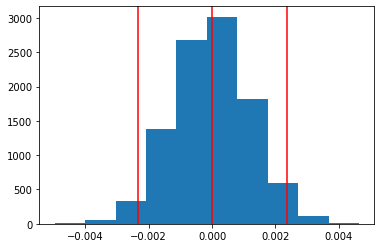

In [35]:
# plotting the sampling distribution : 

plt.hist(p_diffs)  ;

# plotting the boundaries of 95% confidence interval:
plt.axvline(np.mean(p_diffs),color = 'red');
plt.axvline(np.percentile(p_diffs,2.5),color = 'red');
plt.axvline(np.percentile(p_diffs,97.5),color = 'red');

-------------------------------------------------------------------------------------------------------------------------------------------------

#### Finally, We are going to calculate the p-value in order to assess our hypothesis.

In [36]:
# Calculatting p_value  
# In other words, The proportion of the p_diffs are greater than the actual difference observed in our dataset.

p_diffs = np.array(p_diffs)
print('P-Value = ',(p_diffs > actual_diff).mean());

P-Value =  0.8571


### Conclusion:
> The calculated P-value is > Type 1 error of 5%.

>  So, We can conclude that: There is no evidence to reject the null hypothesis. In other words, there is no statistically significant effect of the new landing page on the conversion rates.

------------------------------------------------------------------------------------------------------

### Another way for calculating p-value 

In [37]:
# We can use a built-in codes which are more easier using proportions_ztest :

old_converted = df2[df2.group == 'control'].converted.sum() 
new_converted = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].converted.count()
n_new = df2[df2.group == 'treatment'].converted.count()

z_score , p_value = sm.stats.proportions_ztest([old_converted,new_converted],[n_old,n_new],alternative = 'smaller')

print('Z_score = ',z_score ,'    &     P_value = ',p_value)

Z_score =  1.3109241984234394     &     P_value =  0.9050583127590245


### **Interpreting results:**

> * Z_score refers to the how many standard deviations of our data points away from our mean.
* P_value is a statistical significance measure to assess our hypothesis.

### Conclusion:
> - As our p_value is far higher than 0.05 which is a type 1 error, so we can't reject the null hypothesis.
- Finally, we can't tell that there is neither significant statistical nor practical difference in conversion rates for both old and new landing pages.

-----------------------

<a id='regression'></a>
## Part III - Regression

> * Since we are measuring converted or non-converted instances (i.e Categorical variable )
* Then we may use the logistic regression

1) Preparing for fitting logistic regression model

In [38]:
# Getting dummy variables for new and old web pages
df2[['ab_page_new' , 'ab_page_old']] = pd.get_dummies(df2['landing_page'])

# Dropping a column and consider it as a baseline (i.e if old then new web page) 
df2.drop(columns = 'ab_page_old',inplace = True)


# Initialize a column for the intercept
df2['intercept']=1

# Assigning the predectied feature to a variable
y= df2['converted']

# Assigning the predectors to a variable
x = df2[['intercept','ab_page_new']]

2) fitting the logistic model

In [39]:
log_mod = sm.Logit(y,x)
res = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


3) Getting the results summary

In [40]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-09-18 18:07 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page_new  -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

4) Fitting the result parameters for interpretations

In [41]:
1/np.exp(res.params[1])

1.0151020136964701

### Interpretations:
> In case the landing_page was the new_age, Then for every user there is a multiplicative change in the conversion rate by 1.015. 

### Conclusion:
>- As we can see the p-value of ab_page is 0.1899 which is higher than 0.05.
- So again we can't reject the null hypothesis. We can see that there is neigther statistical nor practical significant difference in conversion rates due to landing_page.

> - The result is different from part 2 , due to the differrence of hypothesis or which conversion rate is larger than the other. The value differs from the value I found in part II because part III is two sided (two-tailed) test and Part II is a one sided test (one-tailed).

-----------------

## A/B testing results summary

>  There is neither statistical nor paractical difference in the conversion rates for both old and new pages, as a result of various statistical techniques including : Probability, Hypothesis testing and Z-test and finally the regression models.

> *So, the practical decision should be that the company maintains the old_page, becuse  launching the new page would cost more than it benefits in terms of conversions.*

-----------------------------------------------------

#### Creating an HTML version of our EDA analysis:

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'EDA_AB_Testing.ipynb'])

0

-------------------------------------------------------------------------------------------------------------------------